In [1]:
# suitable habitat for sable fish, as a case study
# first on 'current' habitat using historical data - glorys data
# later on 'projections' - dowsncaled data

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') # filter some warning messages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
# Generals
ldp = '~/Documents/LargeData/' # data folder
months=['January','February','March','April','May','June','July','August','September','October','November','December']

# reginoal domain
ldom = np.array([[42.9, 48.4],[-126, -123]]) 
# QIN domain
qbox = np.array([[-124.05,-124.33,-125.07,-124.774,-124.05],[46.53,47.4,47.4,46.53,46.53]]) 


In [4]:
#get bathymetry from ETOPO1
fn = ldp+'/Etopo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fn)
ds_topo.close()
topo = ds_topo.z  #(10801, 21601)
topo2=topo.sel(y=slice(ldom[0,0],ldom[0,1]),x=slice(ldom[1,0],ldom[1,1]))
x = topo2.x  #21601
y = topo2.y   #10801
X,Y=np.meshgrid(x,y)

In [5]:
# QIN mask
qin = xr.open_dataset(ldp+'QIN/qin_mask2.nc')
qin.close()
qin.coords['lon'] = np.mod(qin.coords['lon'] + 180,360) - 180
qin = qin.polygon_mask.sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
qin = qin.where(qin!=0,np.nan)

# number of pixels in the mask
npx = qin.count(dim=['lat','lon']).values
#print(npx)

#qin.plot()

# Sablefish
### Depth: 175-1,450m
### Distance from shore: 0-241km
### Timing: Dec-March for spawning
## Temperature; 4.72-12.85C (2.28-20.56C) for adults
#### 3.10-8.3 for spawning (?)
## Oxygen (O2): 35.13-298.72 mmol/m3

In [6]:
# sablefish characteristics
t1, t2 = 4.72, 12.85
o1, o2 = 35.123, 298.72
o1 = o1 / 44.661  # conversion to ml/l
o2 = o2 / 44.661  
d1, d2 = 175, 1450

In [34]:
def suit_hab_ind(fn, var, depth, th1, th2, fish):
    
    ds_Ts = xr.open_dataset(fn)
    ds_Ts.close()
    ds_Ts.coords['lon'] = np.mod(ds_Ts.coords['lon'] + 180,360) - 180
    ds_Ts = ds_Ts[var].sel(lat=slice(ldom[0,0],ldom[0,1]),lon=slice(ldom[1,0],ldom[1,1]))
    ds_Ts = ds_Ts*qin
    ds_Ts = ds_Ts.where((ds_Ts>=th1)&(ds_Ts<=th2), np.nan)

    Sh_Ts = np.round(ds_Ts.count(dim=['lat','lon']).values*100/npx,1)

    plt.figure(figsize=(8,4))
    plt.plot(ds_Ts.time, Sh_Ts, zorder=2)
    plt.grid(True, alpha=0.3, zorder=1)
    plt.ylabel('% of suitable habitat')
    plt.title('QIN '+var+' T - '+fish)
    plt.show()

    Sh_Ts = Sh_Ts.reshape((int(len(Sh_Ts)/12)), 12)
    plt.figure(figsize=(5,8))
    plt.pcolor(range(1,13),np.unique(ds_Ts.time.dt.year.values),Sh_Ts, vmin=0, vmax=100, cmap='YlOrBr_r')
    plt.colorbar()
    plt.title('QIN '+var+' T - '+fish)
    plt.show()

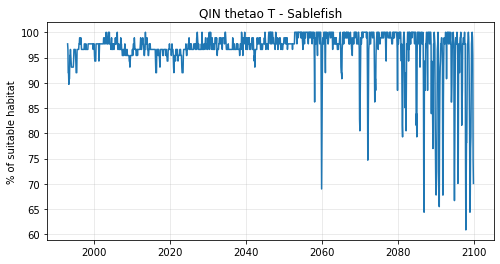

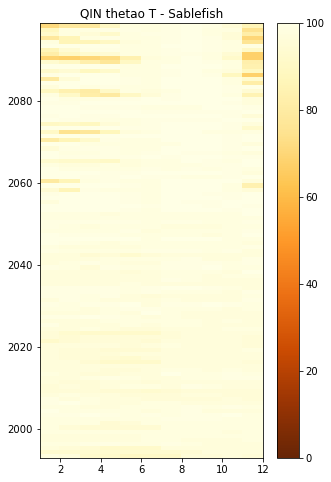

In [42]:
#fn = ldp+'QIN/downscaled_data/bottomT/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc'
fn = ldp+'QIN/downscaled_data/bottomT/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_thetao_bottom_depth_None_0.nc'
suit_hab_ind(fn, 'thetao', 'bottom', t1, t2, 'Sablefish')

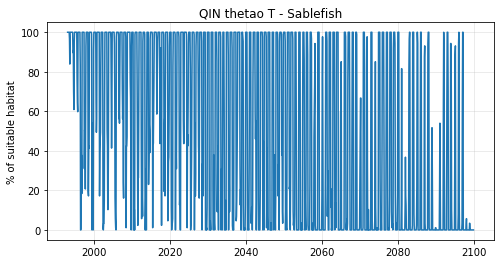

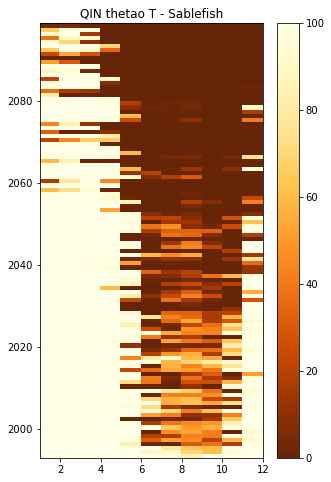

In [43]:
#fn = ldp+'QIN/downscaled_data/surfaceT/GFDL-ESM4_r1i1p1f1_sd+ba_final_thetao_surface_depth_5_0.nc'
fn = ldp+'QIN/downscaled_data/surfaceT/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_thetao_surface_depth_5_0 (4).nc'
suit_hab_ind(fn, 'thetao', 'surface', t1, t2, 'Sablefish')

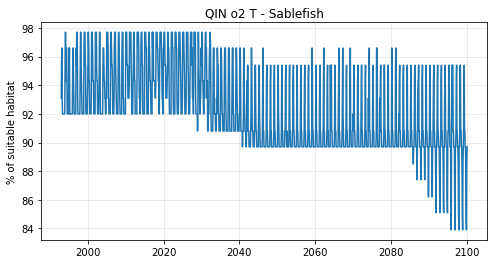

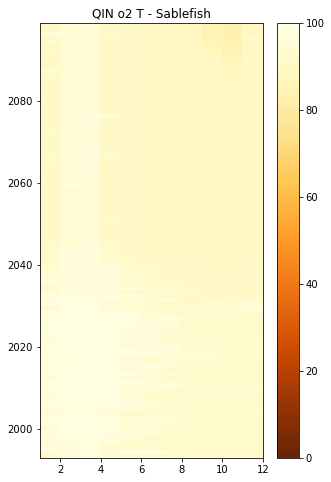

In [41]:
#fn = ldp+'QIN/downscaled_data/bottomO2/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc'
fn = ldp+'QIN/downscaled_data/bottomO2/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_o2_bottom_depth_None_0.nc'
suit_hab_ind(fn, 'o2', 'Bottom', o1, o2, 'Sablefish')

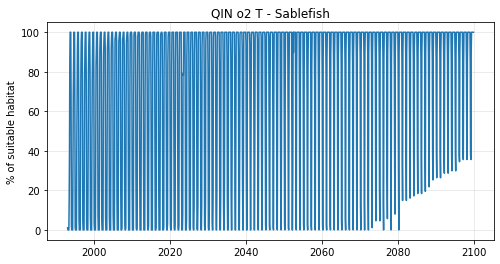

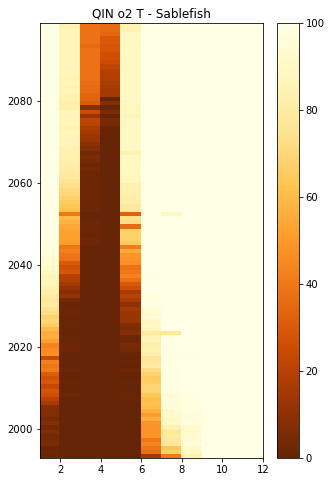

In [40]:
#fn = ldp+'QIN/downscaled_data/surfaceO2/IPSL-CM6A-LR_r1i1p1f1_sd+ba_final_o2_surface_depth_5_0.nc'
fn = ldp+'QIN/downscaled_data/surfaceO2/ACCESS-ESM1-5_r1i1p1f1_sd+ba_final_o2_surface_depth_5_0 (2).nc'
suit_hab_ind(fn, 'o2', 'Surface', o1, o2, 'Sablefish')